In [7]:
import pandas as pd # type: ignore
# from numba import njit # pb dependance numpy 2.3 or less ...


sample = pd.read_csv('c_sample.csv') # nrows=1000 pour limiter

print(sample.head())

numcols = len(sample.columns)
print(f'Number of columns: {numcols}')

# on a 400 colonnes pour 400 échantillons dans le fichier annot_projet.csv
# je dois créer un dataframe qui contiendra les résultats : id_echantillon / age réel / age prédit
# de taille
results = pd.DataFrame(columns=['id_echantillon', 'age_reel', 'age_predit','train'])

   207700470022_R08C01  207686150104_R02C01  207700460080_R08C01  \
0             0.523736             0.528327             0.503596   
1             0.939209             0.927995             0.933160   
2             0.963040             0.957699             0.945989   
3             0.965126             0.970401             0.954996   
4             0.158705             0.140177             0.135465   

   207700470049_R01C01  207805820146_R07C01  207700470041_R01C01  \
0             0.563247             0.591387                  NaN   
1             0.936975             0.934742             0.905153   
2             0.948213             0.950295             0.950142   
3             0.963225             0.969372             0.960981   
4             0.152375             0.149534             0.121757   

   207700470049_R03C01  207700470024_R05C01  207705770040_R06C01  \
0             0.440980             0.537029             0.493120   
1             0.943157             0.937065   

In [8]:
# gestion des NA ? # immputation par la moyenne des colonnes (souvent utilisé) ?
# test différents modèles : elasticnet (avec et sans PCA avant) et aussi xgboost, réseau de neurones ...

## Prédiction d'âge biologique avec Elastic Net
Approche : chargement des matrices beta, alignement avec les métadonnées d'âge, imputation simple par moyenne colonne, standardisation, puis ElasticNetCV avec validation croisée interne. On visualise les prédictions train vs test.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8')

# Chargement des données
annot = pd.read_csv('c_sample.csv') # nrows = 1000 pour limiter
beta = pd.read_csv('beta_toy.csv', index_col=0)  # lignes: CpG, colonnes: échantillons
cpg_names = pd.read_csv('cpg_names_projet.csv')['cpg_names']

# On restreint aux CpG présents dans la liste (sécurité)
beta = beta.loc[beta.index.intersection(cpg_names)]

# Alignement des échantillons entre beta et annotations
annot = annot.rename(columns={'Sample_description': 'sample_id'})
common_samples = annot['sample_id'].isin(beta.columns)
annot_filtered = annot.loc[common_samples].set_index('sample_id')
beta_aligned = beta[annot_filtered.index]  # colonnes dans le même ordre

# Transpose pour avoir les échantillons en lignes, imputation simple (moyenne colonne)
X = beta_aligned.T
X = X.fillna(X.mean())
y = annot_filtered['age']

print(f'Shape features: {X.shape}, Shape target: {y.shape}')

Train: (320, 1000), Test: (80, 1000)


R2 train: 0.912 | test: 0.811
MAE train: 4.92 | test: 8.18


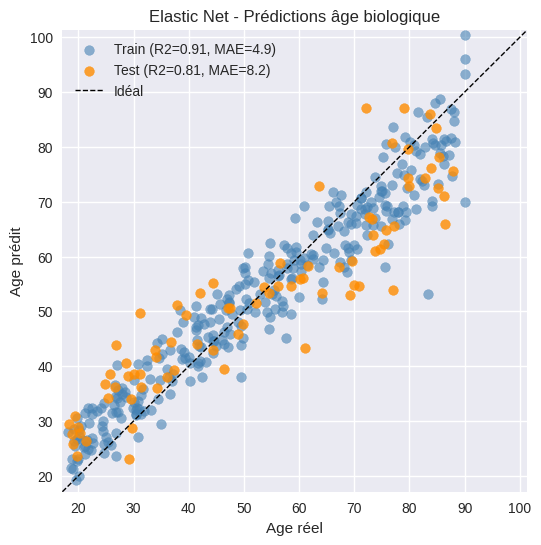

In [ ]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train: {X_train.shape}, Test: {X_test.shape}')

# Pipeline standardisation + ElasticNet avec validation croisée interne
enet_cv = ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9, 1.0],
                     alphas=np.logspace(-4, 0, 20),
                     cv=5,
                     max_iter=10000,
                     n_jobs=-1,
                     random_state=42)
pipe = Pipeline([('scaler', StandardScaler()), ('enet', enet_cv)])
pipe.fit(X_train, y_train)

# Prédictions
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

# Scores
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)
mae_train = mean_absolute_error(y_train, y_pred_train)
mae_test = mean_absolute_error(y_test, y_pred_test)

print(f'R2 train: {r2_train:.3f} | test: {r2_test:.3f}')
print(f'MAE train: {mae_train:.2f} | test: {mae_test:.2f}')

# Graphique train vs test
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(y_train, y_pred_train, c='steelblue', alpha=0.6, label=f'Train (R2={r2_train:.2f}, MAE={mae_train:.1f})')
ax.scatter(y_test, y_pred_test, c='darkorange', alpha=0.8, label=f'Test (R2={r2_test:.2f}, MAE={mae_test:.1f})')
lims = [min(y.min(), y_pred_train.min(), y_pred_test.min()) - 1, max(y.max(), y_pred_train.max(), y_pred_test.max()) + 1]
ax.plot(lims, lims, 'k--', linewidth=1, label='Idéal')
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Age réel')
ax.set_ylabel('Age prédit')
ax.legend(frameon=False)
ax.set_title('Elastic Net - Prédictions âge biologique')
plt.show()